# Critical Heat Flux (CHF) Prediction

**Inputs**

- `D (m)`: Diameter of the test section ($0.002 - 0.016~m$) 
- `L (m)`: Heated length ($0.07 - 15.0~m$)
- `P (kPa)`: Pressure ($100 - 20,000~kPa$)
- `G (kg m-2s-1)`: Mass flux ($17.7 - 7712.0~\frac{kg}{m^2\cdot s}$)
- `Tin (C)`: Inlet temperature length ($9.0 - 353.62 ^\circ C$)
- `Xe (-)`: Outlet equilibrium quality ($-0.445 - 0.986$)

**Output**

- `CHF (kW m-2)`: Critical heat flux ($130.0 - 13345.0~\frac{kW}{m^2}$)

The CHF dataset was taken from the Nuclear Regulatory Commission CHF database. This dataset was generated from vertical water-cooled uniformly heated tubes, producing 24,579 samples from 59 different sources of measurements. The dataset was collected over experimental measurements spanning 60 years of CHF data collection methods such as visual identification, physical burnout, changes in the test section resistances, and the usage of thermocouples. The parameters collected consist of pressure ($P$), test section diameter ($D$), heated length ($L$), mass flux ($G$), inlet temperature ($T_{in}$), outlet equilibrium quality ($X$), and $CHF$. 

Negative quality $X$ could represent a subcooled fluid. The database was limited in terms of diameter (2 $<$ D $<$ 25 mm), $L/D$ ratio ($L/D$ $>$ 50 for X $>$ 0, $L/D$ $>$ 25 for X $<$ 0), pressure (100 $\leq$ P $\leq$ 21,000 kPa) and mass flux (0 $\leq$ G $<$ 8,000 kg/m2/s). The measured data was also not equally distributed over the whole span, and no data beyond $D$ = 16 mm was found in the database. **Our goal is to identify optimal ML models with pyMIASE that can predict CHF accurately given other geometrical parameters and boundary conditions ($D, L, P, G, T_{in}, X$).**

**Important Note**: This dataset is confidential, it is not open-sourced with pyMAISE and can be requested directly from the OECD Nuclear Energy Agency (NEA). In this notebook, we provide 2500 synthetic samples that mimic the real ones (split into 2000 train and 500 test samples). The synthetic samples were generated by adding random noise to the real experiments. The user only needs to replace the synthetic csv files below with the ones from NEA. More information about the benchmark can be found at this link: https://www.oecd-nea.org/jcms/pl_89619/benchmark-on-artificial-intelligence-and-machine-learning-for-scientific-computing-in-nuclear-engineering-phase-1-critical-heat-flux-exercise-specifications?details=true

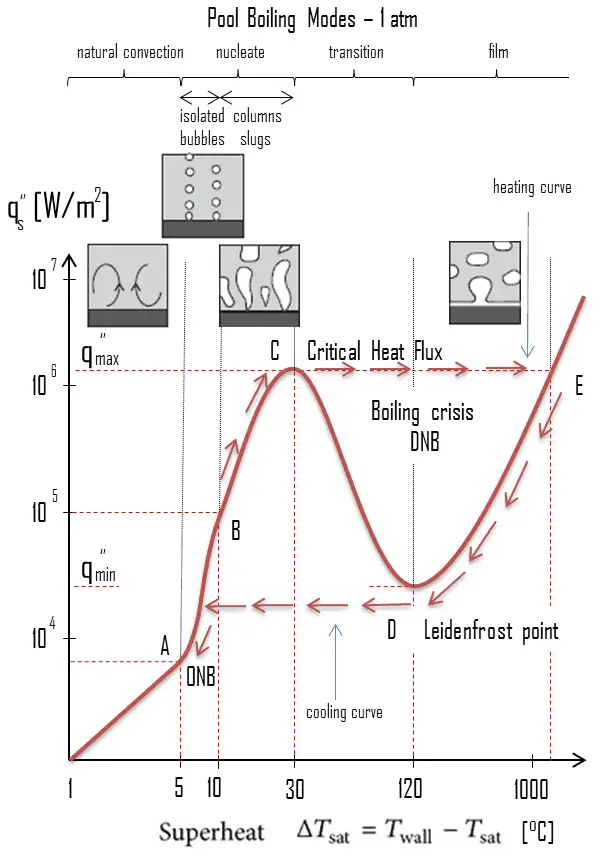

In [1]:
# Import other packages
import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler

# pyMAISE specific imports
from pyMAISE.datasets import load_chf
from pyMAISE.preprocessing import correlation_matrix, scale_data, read_csv
import pyMAISE as mai
import pyMAISE.explain as explain

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 12,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

## Initialization and Preprocessing

We define a regression problem and load the data using `pyMAISE.datasets.load_chf`. Here, we set `cuda_visible_devices="-1"` to define a CPU-only job as this dataset is reasonably small.

In [2]:
# Initialize pyMAISE settings
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

# Load data
train_data, xtrain, ytrain, test_data, xtest, ytest = load_chf()

The CHF dataset has six inputs listed below with 2500 total samples, 2000 of which are for training.

In [3]:
xtrain

<xarray.DataArray (index: 2000, variable: 6)>
array([[1.01591633e-02, 2.98755621e+00, 1.99910352e+04, 5.20754066e+02,
        2.60238993e+02, 3.36618827e-01],
       [9.61641659e-03, 5.48464942e+00, 7.07735164e+03, 2.74115374e+03,
        2.31174290e+02, 4.12976136e-01],
       [7.58601972e-03, 7.66842472e-01, 1.42533415e+04, 4.03670025e+03,
        2.92868636e+02, 2.48984031e-02],
       ...,
       [8.05556451e-03, 1.03945144e+00, 6.74277013e+03, 2.03124398e+03,
        1.31730956e+02, 1.67113569e-01],
       [1.14979333e-02, 1.78439632e+00, 6.83238523e+03, 1.94423864e+03,
        2.66335292e+02, 3.57005646e-01],
       [7.48060708e-03, 2.97318942e+00, 1.39846734e+04, 4.10568657e+03,
        3.22802524e+02, 2.77580848e-01]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'D (m)' 'L (m)' 'P (kPa)' ... 'Tin (C)' 'Xe (-)'

We have one output, CHF.

In [4]:
ytrain

<xarray.DataArray (index: 2000, variable: 1)>
array([[ 377.05549841],
       [ 956.92913687],
       [3091.19358014],
       ...,
       [3725.37959666],
       [2066.25518823],
       [ 969.10507166]])
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * variable  (variable) object 'CHF (kW m-2)'

Below we have the correlation matrix for this dataset.

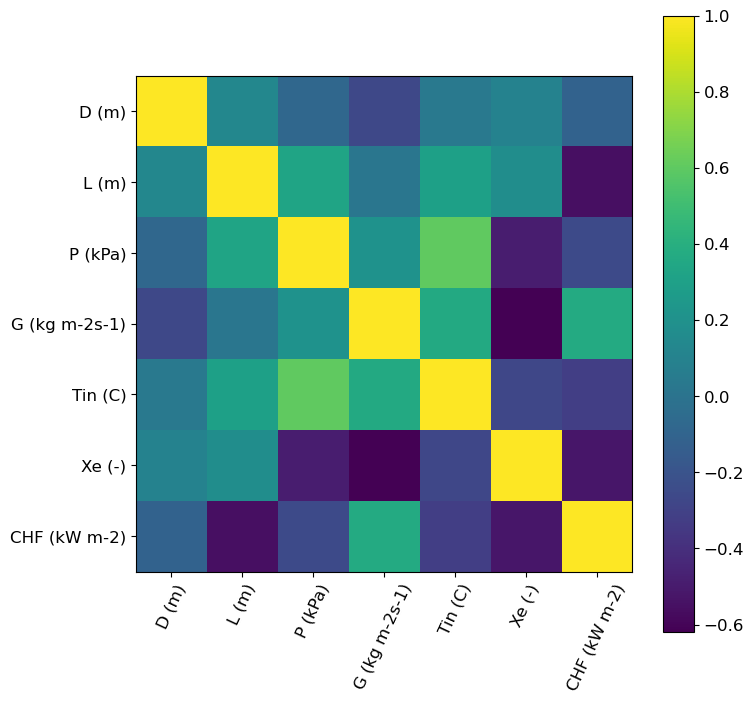

In [5]:
correlation_matrix(xr.concat([train_data, test_data], dim="samples"))
plt.show()

We can see a slightly negative correlation between $L$ and $X$ with $CHF$, while $G$ has a slightly positive correlation.

We then min-max scale all data before hyperparameter tuning.

In [6]:
# Min-max scale data
xtrain, xtest, xscaler = scale_data(xtrain, xtest, scaler=MinMaxScaler())
ytrain, ytest, yscaler = scale_data(ytrain, ytest, scaler=MinMaxScaler())

## Model Initialization

We will examine the performance of 7 regression models:

- linear: ``Linear``,
- lasso: ``lasso``,
- support vector machine ``SVM``,
- decision tree ``DT``,
- random forest ``RF``,
- k-nearest neighbors ``KN``,
- dense feedforward neural networks ``FNN``.

For hyperparameter tuning, we initialize all classical models as scikit-learn defaults. For the FNN we define input and output layers with possible dropout layers. These layers include hyperparameter tuning of their number of nodes, use of sublayers, and the rate of dropout. The dense hidden layers include tuning of their depth.

In [7]:
model_settings = {
    "models": ["Linear", "Lasso", "SVM", "DT", "RF", "KN", "FNN"],
    "FNN": {
        "structural_params": {
            "Dense_hidden": {
                "num_layers": mai.Int(min_value=0, max_value=4),
                "units": mai.Int(min_value=25, max_value=300),
                "activation": "relu",
                "kernel_initializer": "normal",
                "sublayer": mai.Choice(["Dropout_hidden", "None"]),
                "Dropout_hidden": {
                "rate": mai.Float(min_value=0.4, max_value=0.6),
                },
            },
            "Dense_output": {
                "units": ytrain.shape[-1],
                "activation": "linear",
                "kernel_initializer": "normal",
            },
        },
        "optimizer": "Adam",
        "Adam": {
            "learning_rate": mai.Float(min_value=1e-5, max_value=0.001),
        },
        "compile_params": {
            "loss": "mean_absolute_error",
            "metrics": ["mean_absolute_error"],
        },
        "fitting_params": {
            "batch_size": mai.Choice([16, 32, 64]),
            "epochs": 30,
            "validation_split": 0.15,
        },
    },
}
tuner = mai.Tuner(xtrain, ytrain, model_settings=model_settings)

## Hyperparameter Tuning

The hyperparameter tuning spaces are defined below. We use random search for the classical models as their training is quick, and random search can cover ample parameter space. Bayesian search is utilized for the FNNs as their training is more computationally expensive. Both search methods use 5-fold cross-validation to mitigate bias from the training data. We train 200 classical models from random search and 50 iterations of Bayesian search for neural networks. 

In [8]:
random_search_spaces = {
    "Lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "SVM": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "DT": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "RF": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "KN": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}

start = time.time()
random_search_configs = tuner.random_search(
    param_spaces=random_search_spaces, 
    n_iter=200,
    n_jobs=6,
    cv=5,
)

bayesian_search_configs = tuner.nn_bayesian_search(
    objective="r2_score",
    max_trials=50,
    cv=5,
)
print("Hyperparameter tuning took " + str((time.time() - start) / 60) + " minutes to process.")

Hyperparameter tuning took 73.96480063597362 minutes to process.


After the training, we can see training results for each iteration using the `pyMAISE.Tuner.convergence_plot` function. For the neural networks, we have the following: 

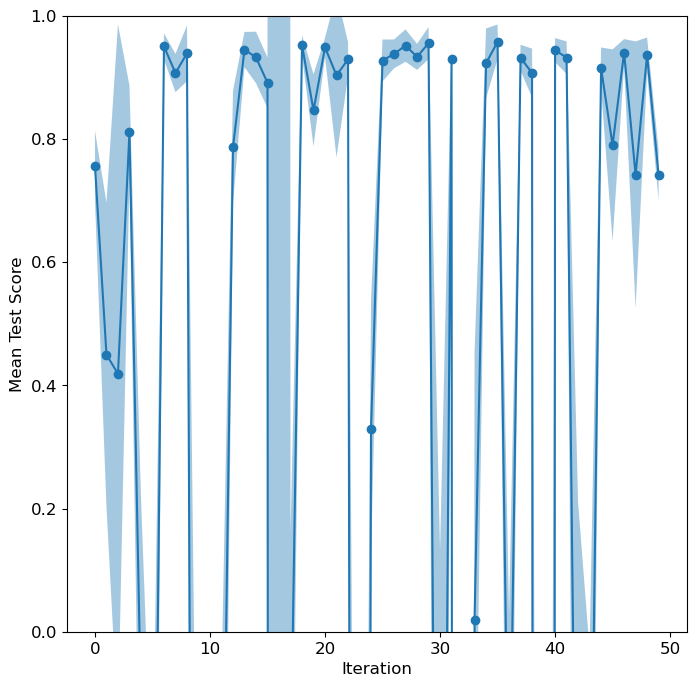

In [9]:
ax = tuner.convergence_plot(model_types="FNN")
ax.set_ylim([0, 1])
plt.show()

The Bayesian search explores the search space but finds several suitable hyperparameter configurations.

## Model Postprocessing

With the top `pyMAISE.Settings.num_configs_saved`, we can pass these parameter configurations to the `pyMAISE.PostProcessor` for model comparison and analysis. For the FNNs, we define the `"epochs"` parameter as 200 for better performance.

In [10]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest), 
    model_configs=[random_search_configs, bayesian_search_configs], 
    new_model_settings={
        "FNN": {"fitting_params": {"epochs": 200}},
    },
    yscaler=yscaler,
)

Below we computed the performance metrics based on the performance of each model on the CHF dataset.

In [11]:
postprocessor.metrics().drop("Parameter Configurations", axis=1)

,Model Types,Train R2,Train MAE,Train MAPE,Train RMSE,Train RMSPE,Test R2,Test MAE,Test MAPE,Test RMSE,Test RMSPE
28,FNN,0.986365,103.772220,6.825958,169.734813,10.393515,0.982595,117.122107,7.448323,175.741550,9.889872
27,FNN,0.982984,118.913585,7.855971,189.614173,13.199173,0.982071,122.738113,7.397123,178.367470,10.144353
26,FNN,0.979994,133.441961,8.667236,205.603631,13.513832,0.981940,123.532763,8.445713,179.017437,12.010333
30,FNN,0.985734,107.426869,6.924668,173.621018,11.157815,0.980867,117.994058,7.380926,184.259399,10.533002
29,FNN,0.983481,116.017691,7.028580,186.829292,10.685879,0.979970,122.542721,7.518259,188.531867,10.251463
16,RF,0.992495,69.093647,4.765204,125.930876,7.632832,0.968418,163.167008,11.409797,236.734321,16.282808
18,RF,0.981478,98.837960,6.694087,197.830787,11.401217,0.966131,166.127115,11.159528,245.155318,15.545880
17,RF,0.982201,103.039753,7.122197,193.929504,11.788951,0.965845,166.647771,11.523654,246.187487,16.254841
20,RF,0.974944,124.769142,8.659886,230.094613,14.449070,0.961339,174.957547,12.069184,261.924436,16.866262
19,RF,0.975033,122.781281,8.752270,229.686419,14.920676,0.956253,186.289271,13.077801,278.621402,18.552053


This data set is not linear, with a poor performance from linear and lasso regression. The remaining four models in order are FNN > RF > KN > DT > SVM with all five models providing reliable performance. KN overfits with a perfect training $R^2$.

Using the `pyMAISE.PostProcessor.print_model` function, we can see all the top performing (based on test $R^2$) models' hyperparameters.

In [12]:
for model in ["Lasso", "SVM", "DT", "RF", "KN", "FNN"]:
    postprocessor.print_model(model_type=model)
    print()

Model Type: Lasso
  alpha: 0.00010584349087740784

Model Type: SVM
  degree: 2
  gamma: scale
  kernel: rbf

Model Type: DT
  max_depth: 41
  max_features: 6
  min_samples_leaf: 1
  min_samples_split: 2

Model Type: RF
  criterion: absolute_error
  max_features: 4
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 98

Model Type: KN
  leaf_size: 21
  n_neighbors: 3
  p: 1
  weights: distance

Model Type: FNN
  Structural Hyperparameters
    Layer: Dense_hidden_0
      units: 290
      sublayer: None
    Layer: Dense_output_0
  Compile/Fitting Hyperparameters
    Adam_learning_rate: 0.00059628038091917
    batch_size: 16
Model: "FNN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 Dense_hidden_0 (Dense)      (None, 290)               2030      


 Dense_output_0 (Dense)      (None, 1)                 291       


Total params: 2,321


Trainable params: 2,321


Non-trainable params: 0


_________________________________________________________________


Below is the network plot for the FNN.

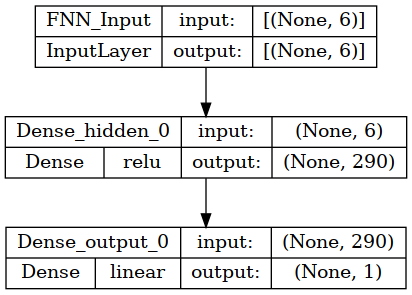

In [13]:
postprocessor.nn_network_plot(
    to_file="./supporting/chf_network.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    show_layer_activations=True,
)

We can use the `pyMAISE.PostProcessor.diagonal_validation_plot` and `pyMAISE.PostProcessor.validation_plot` functions to visualize the performance of these models. Diagonal validation plots show the actual versus predicted outcome. A well-performing model follows $y=x$ on this plot. You can choose what outputs to display on the diagonal validation plot; however, since we have a single output (CHF), a single plot will be generated. Both functions use the top-performing model on test $R^2$ by default.

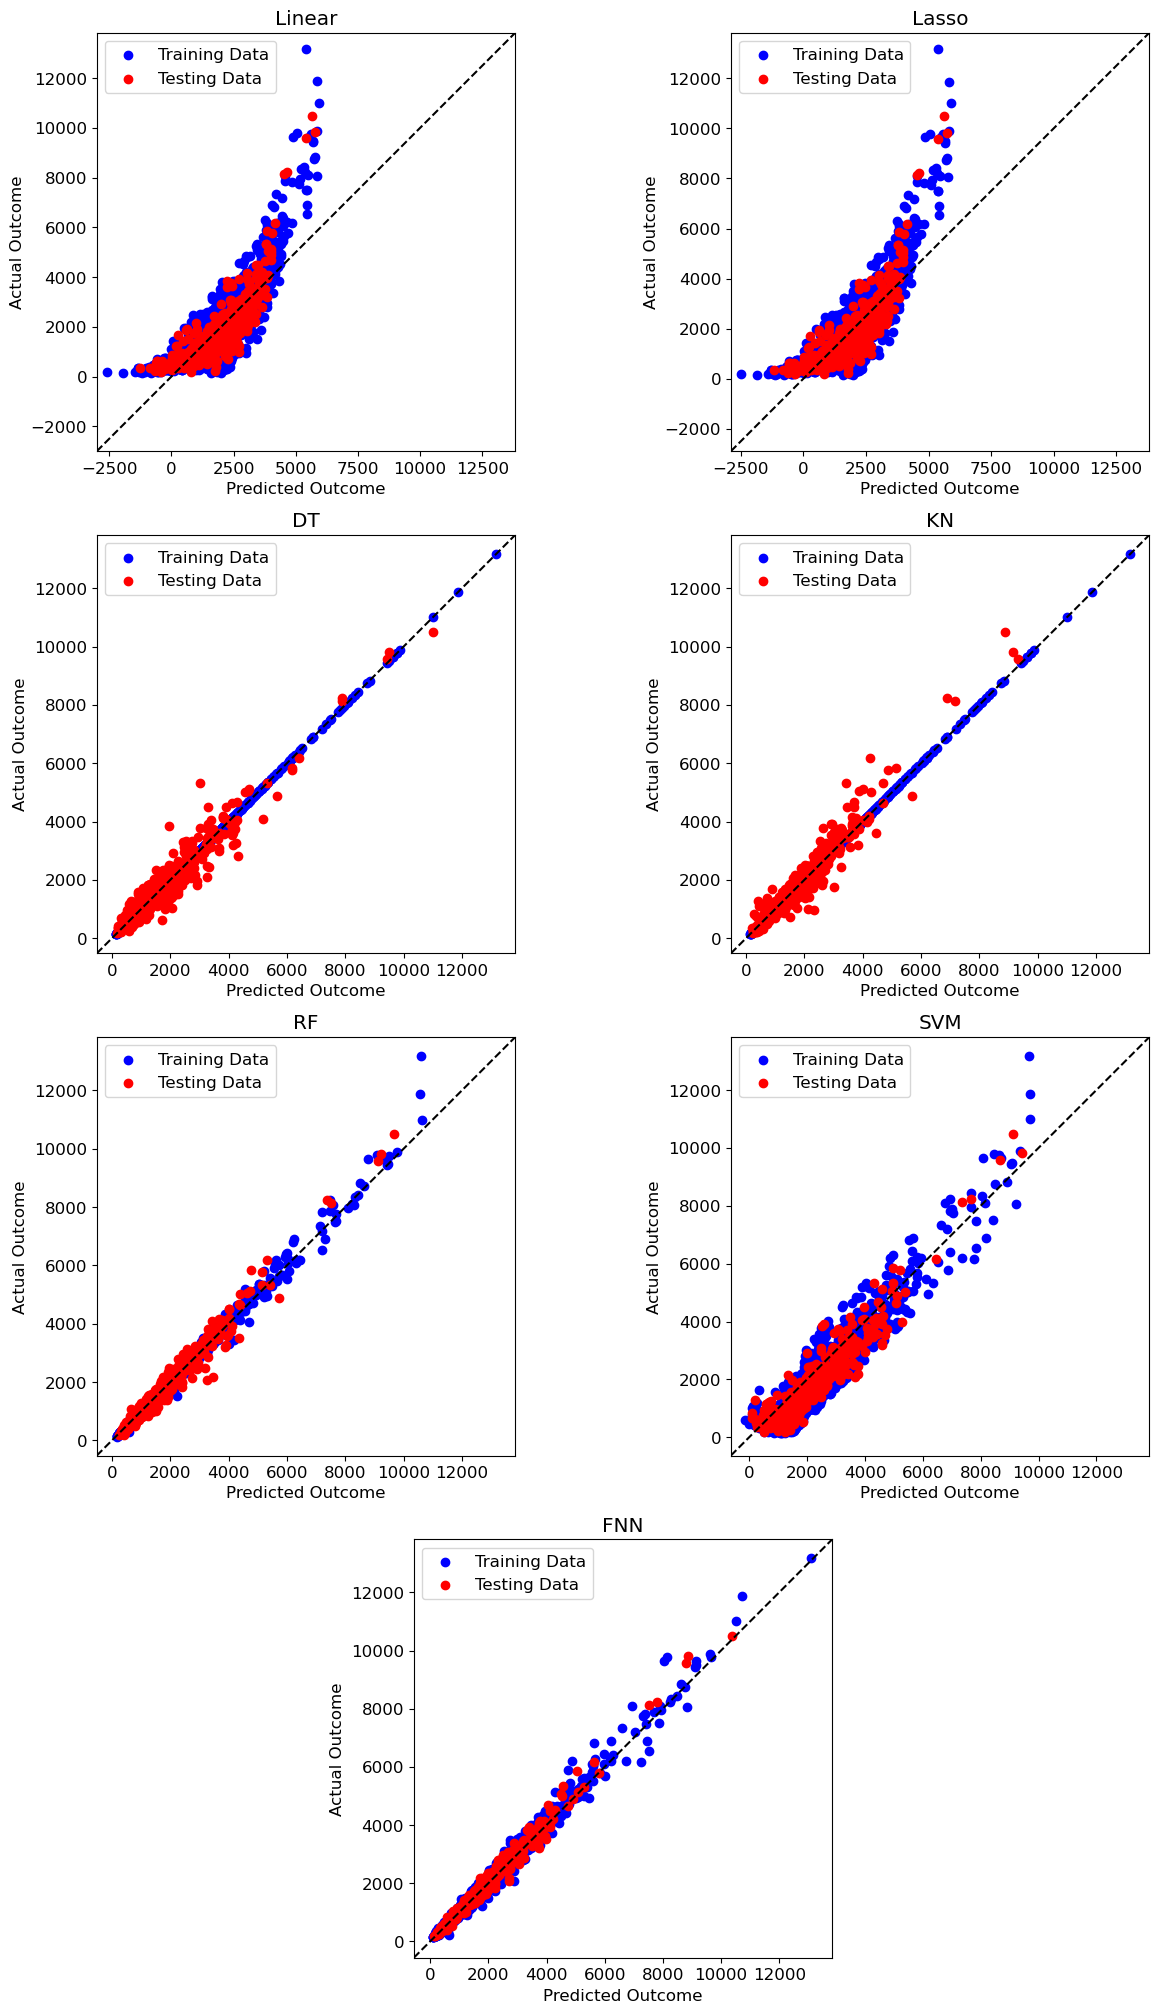

In [14]:
models = np.array([["Linear", "Lasso"], ["DT", "KN"], ["RF", "SVM"]])
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.diagonal_validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.diagonal_validation_plot(model_type="FNN")
ax.set_title("FNN")
plt.show()

All models display a close spread to $y=x$; however, given the more extensive spread, linear models' lack of performance is apparent.

Validation plots show the absolute error of the predicted output relative to the actual outputs of the testing data set.

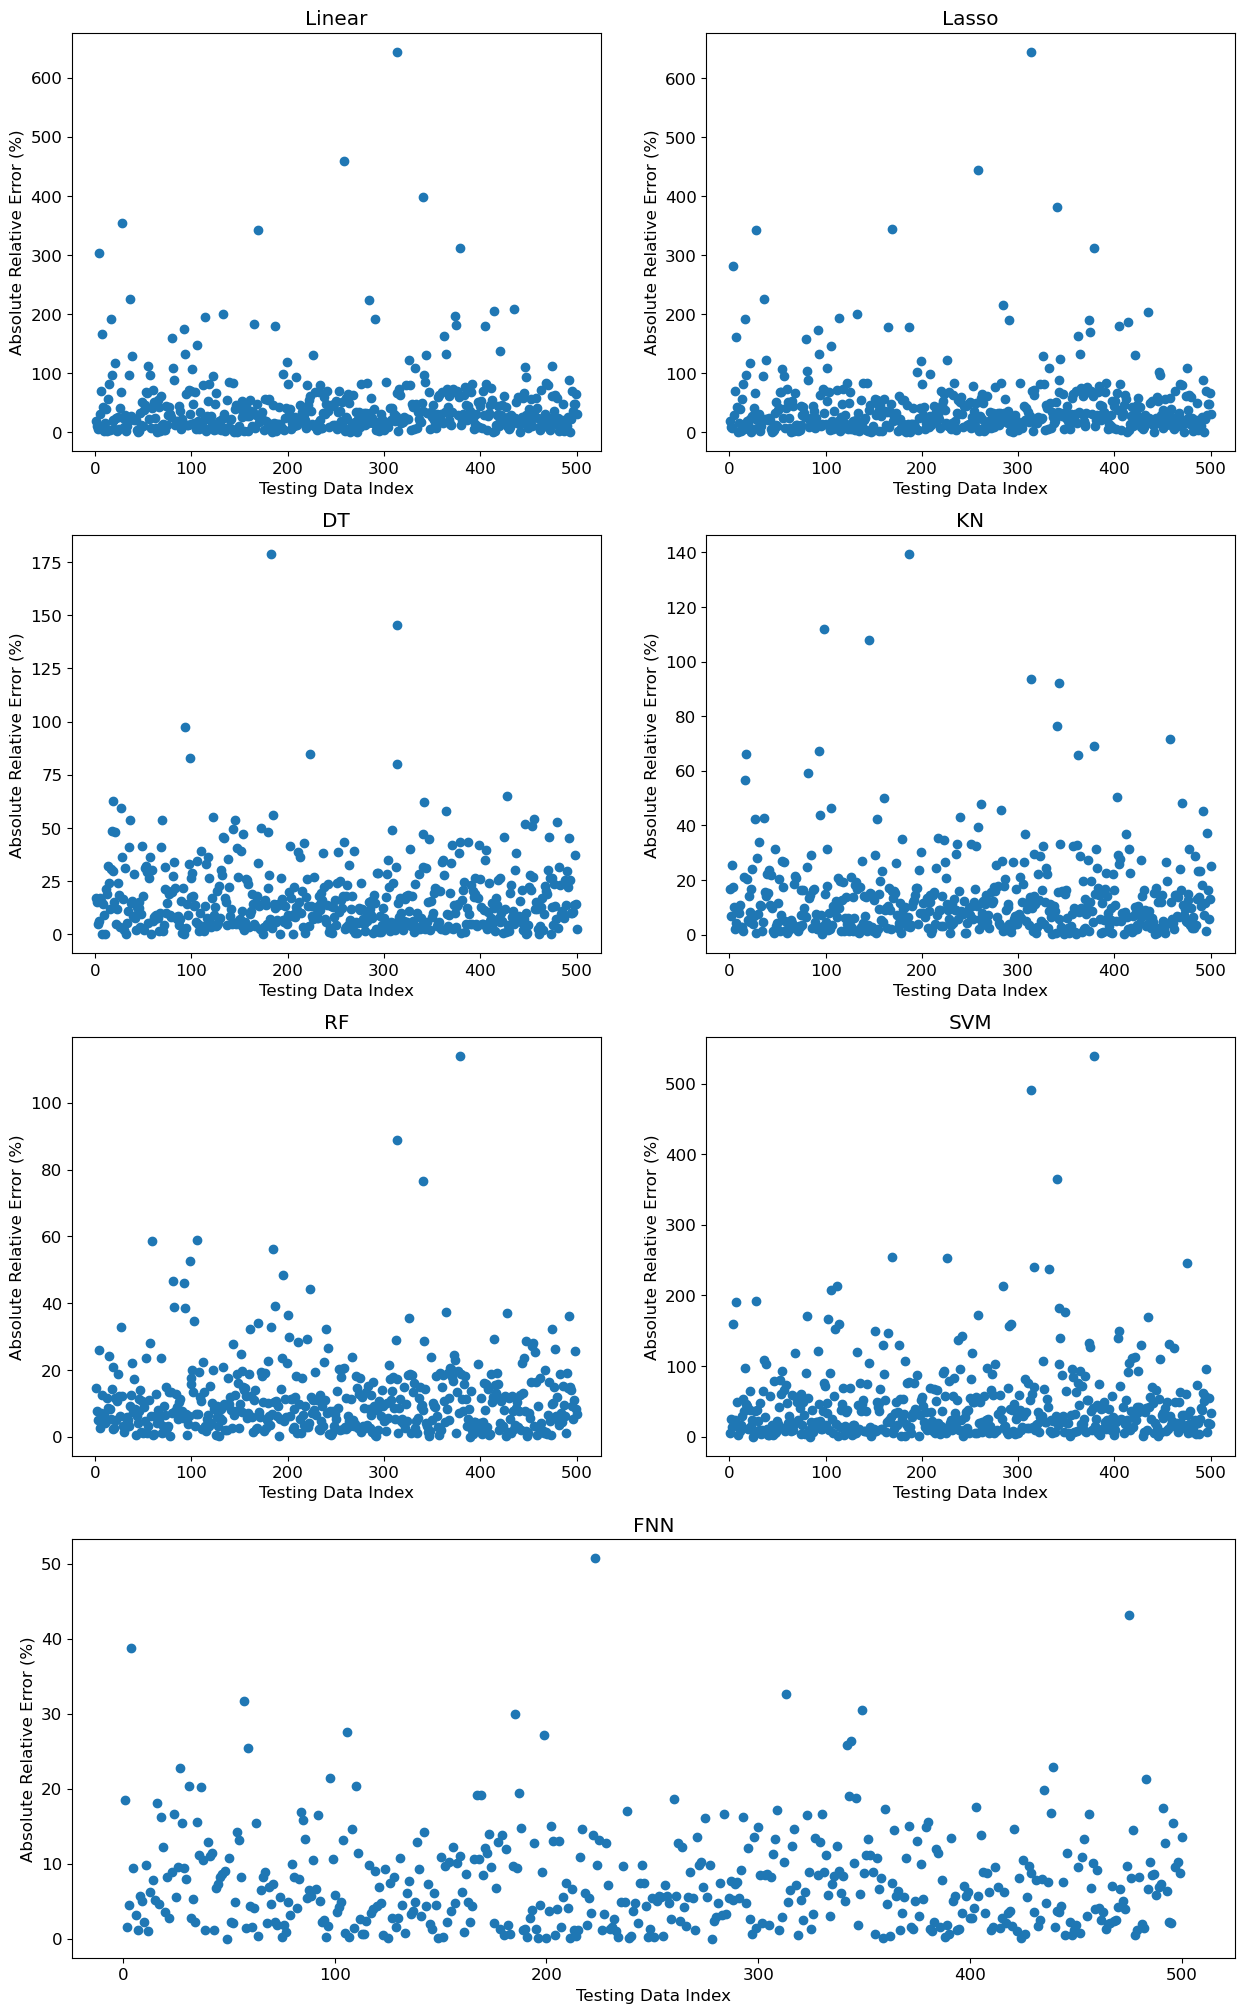

In [15]:
fig = plt.figure(figsize=(15, 25))
gs = fig.add_gridspec(4, 2)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        ax = fig.add_subplot(gs[i, j])
        ax = postprocessor.validation_plot(model_type=models[i, j])
        ax.set_title(models[i, j])
ax = fig.add_subplot(gs[3, :])
ax = postprocessor.validation_plot(model_type="FNN")
ax.set_title("FNN")
plt.show()

Finally, we can see if the FNN is overfit based on its learning curve.

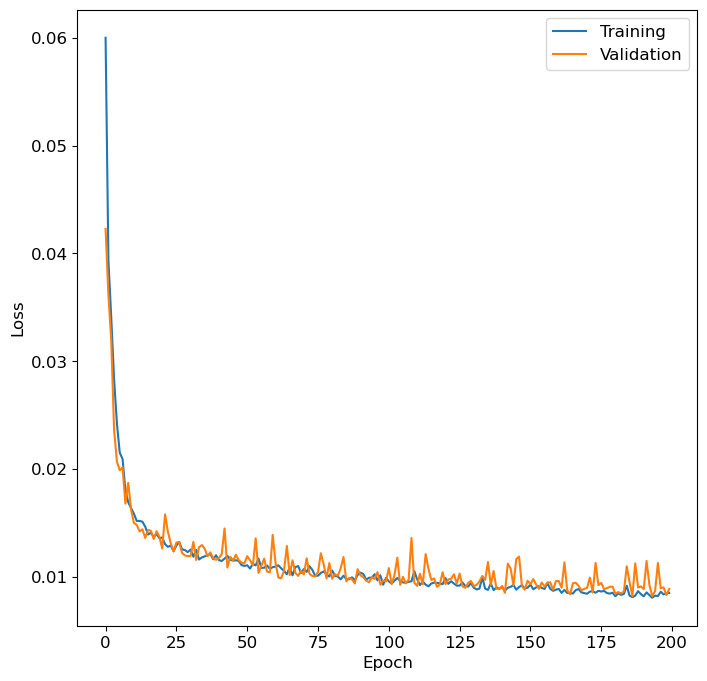

In [16]:
postprocessor.nn_learning_plot()
plt.show()

The FNN is not overfitting, as the validation curve closely follows the training curve.

Finally, using the best FNN model, we can generate new CHF predictions for new experimental setups that do not exist in our data set.

## Explainability Metrics

We start by grabbing our FNN model object and defining our feature and output names to plot in a way that is useful to the analyst. Then, we create an explainability object from our model using those names.

In [17]:
model = postprocessor.get_model(model_type="FNN")

chf_feature_names = [r"$D$ $[m]$", r"$L$ $[m]$", r"$P$ $[kPa]$", r"$G$ $[\frac{kg}{m^2s}]$", r"$T_{In}$ $[^{\circ}C]$", r"$X_e$ $[-]$"]
chf_output_names = [r"$CHF$ $[\frac{kW}{m^2}]$"]

explainer = explain.ShapExplainers(model, X=xtest.values, 
                   feature_names=chf_feature_names, 
                   output_names=chf_output_names)

Next, we can use our explainability object, explainer, to call some different SHAP methods. We will use this to produce feature importance rankings for our model. For this scenario, we will try DeepLIFT, KernelSHAP, and Integrated Gradients. The arguments of each of these functions are as follows: <br>
- **DeepLIFT**: nsamples, the default for this value is None, so the method will automatically use all the provided values in X. To select a random subset of samples from X, set nsamples to the length desired. This parameter determines the number of times to re-evaluate the model when explaining each prediction, so maximizing nsamples will minimize variance of the SHAP values.  
- **IntGradients**: nsamples, again, this is the same parameter as DeepLIFT.  
- **KernelSHAP**: this method takes three arguments: n_background_samples, n_test_samples, and n_bootstrap. n_bootstrap is the same as the nsamples parameter from the DeepLIFT and IntGradients methods; it defines the number of times to re-evaluate the model when explaining each prediction. Since KernelSHAP makes local linear approximations to explain model results, it needs some "training" data to fit these local models. These "training" data are defined by the subset of data you provide to the method from index 0 through n_background_samples. Then, to evaluate these local linear approximations, KernelSHAP also needs a "test" set, this is comprised of the data you provide to the method from index n_test_samples to the end of the dataset. Because we generally want to have a higher number of training points than test points, n_background_samples should be greater than n_test_samples. 

In [ ]:
explainer.DeepLIFT(nsamples=None)
# explainer.IntGradients(nsamples=None)
# explainer.KernelSHAP(n_background_samples=200,
#              n_test_samples=xtest.values.shape[0] - 200,
#              n_bootstrap=200)

/home/npanczyk/pyMAISE/pyMAISE/explain/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/npanczyk/miniconda3/envs/maise/lib/python3.11/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Finally, we call a post-processing function on our results to calculate mean values of our shap scores (among other things). Then, we can plot our results to visualize feature importance rankings for all three methods with both a beeswarm plot and a mean value bar plot. 

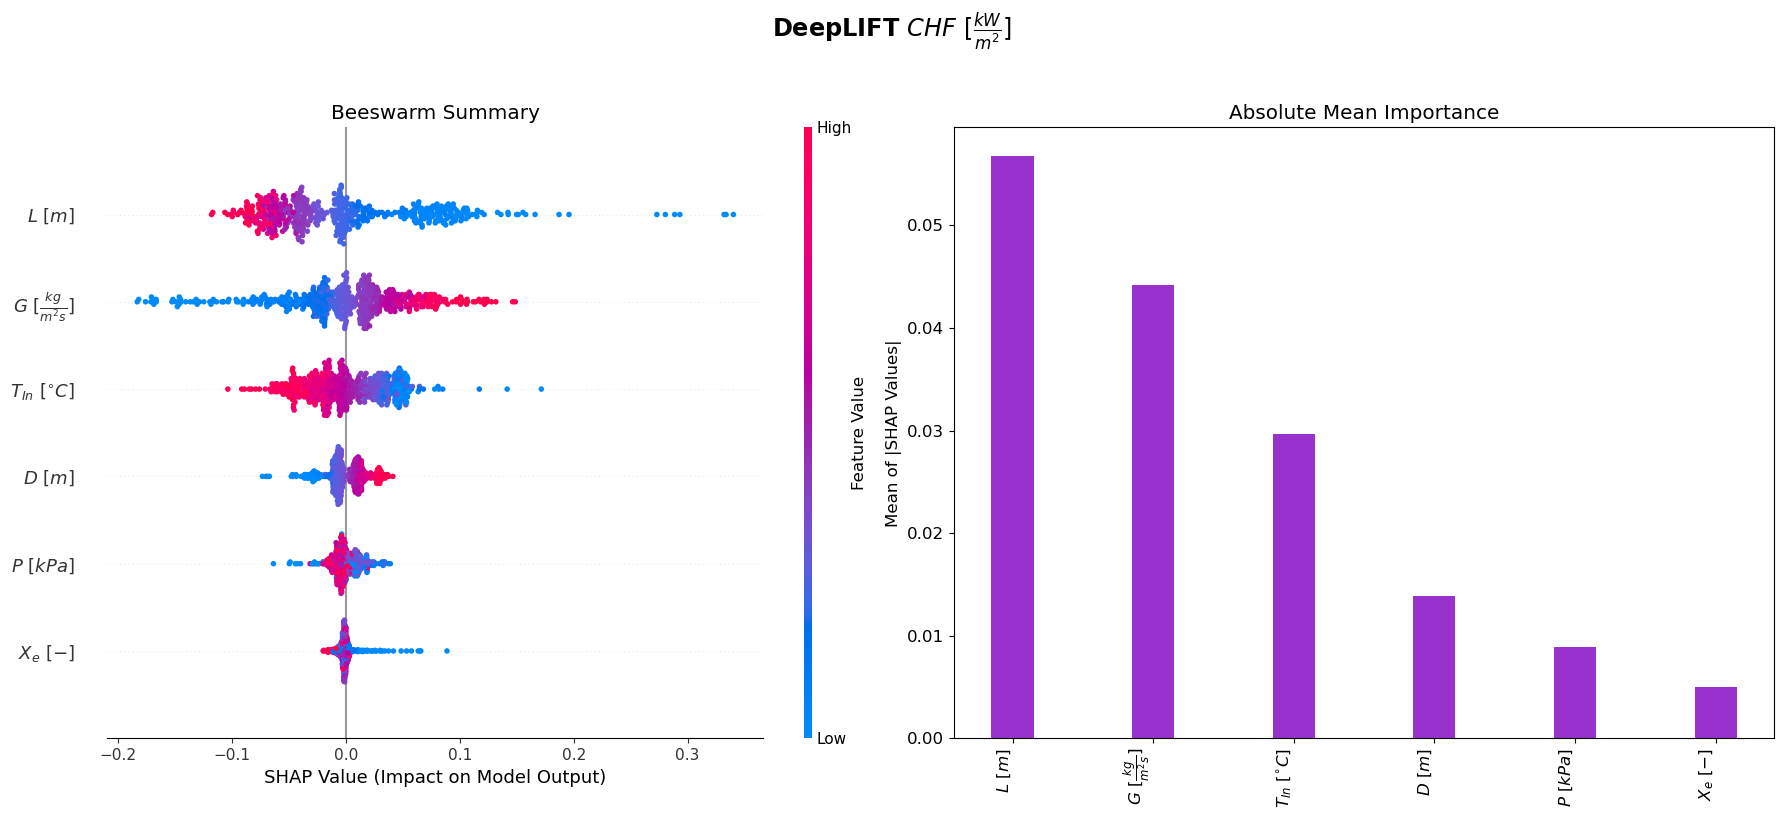

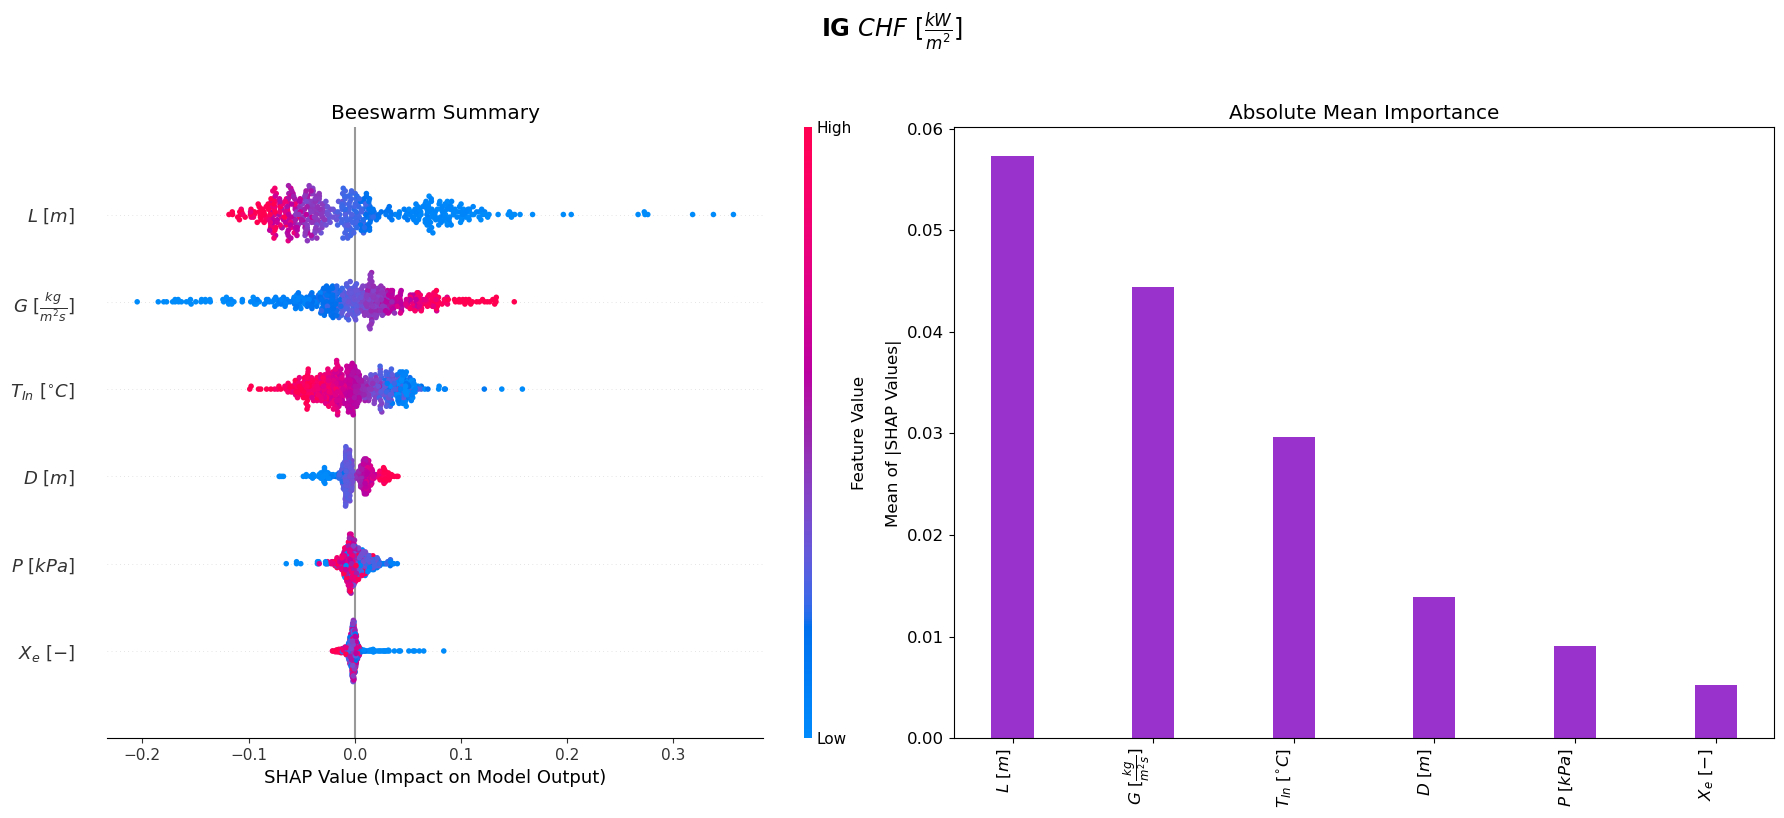

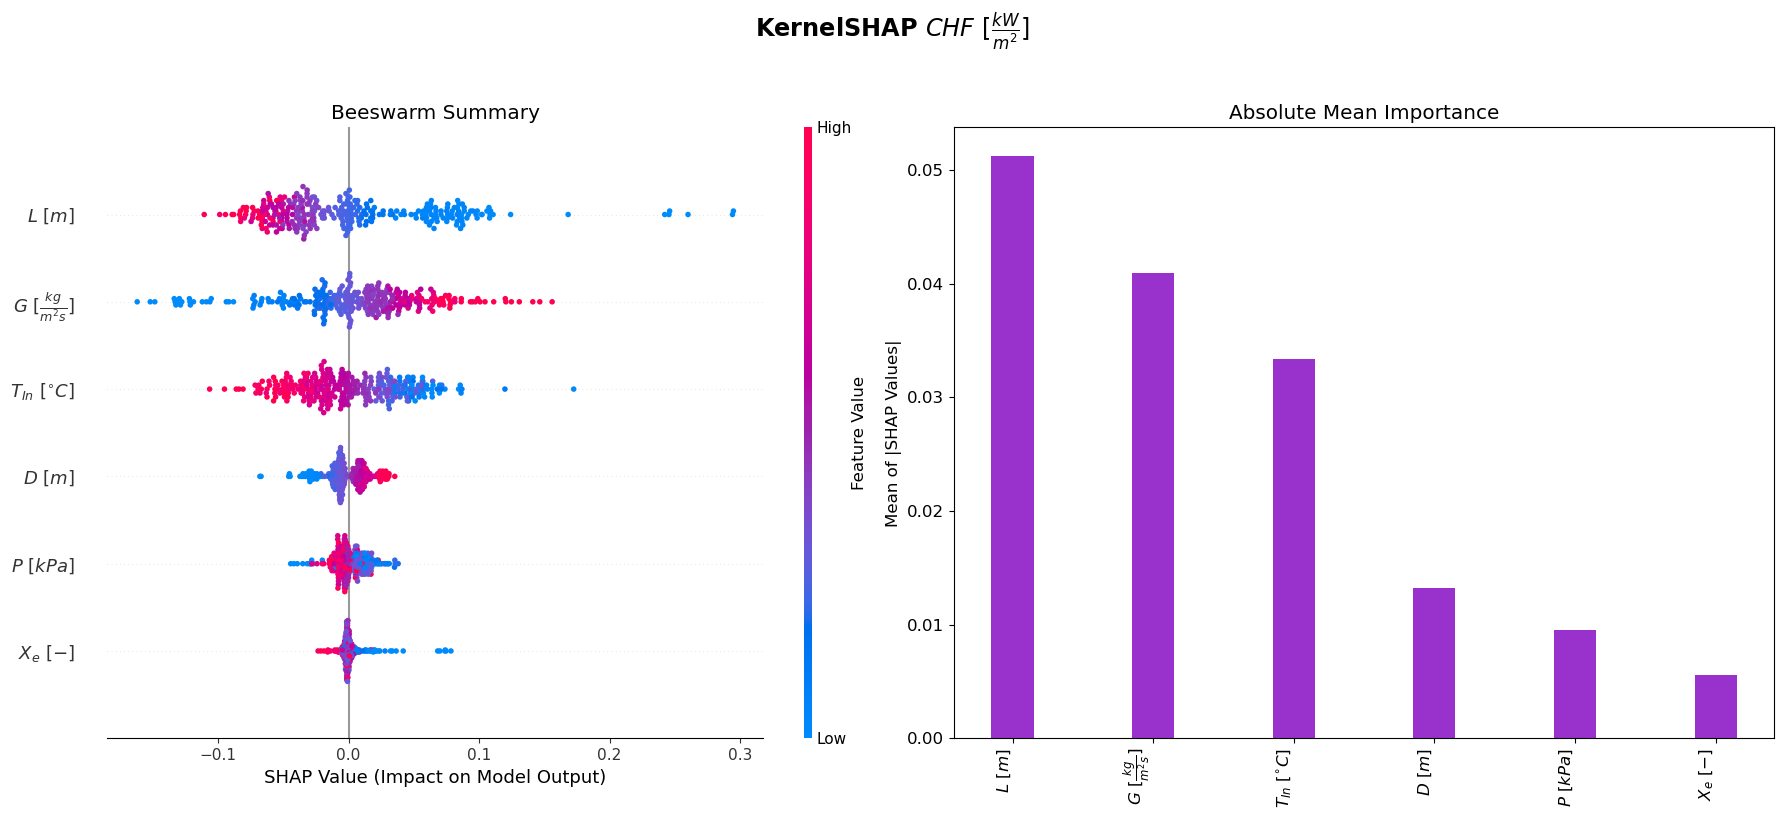

In [ ]:
explainer.postprocess_results()
# explainer.plot()

In [ ]:
explainer.plot_bar_only(run_name='kan-paper-chf-dl')



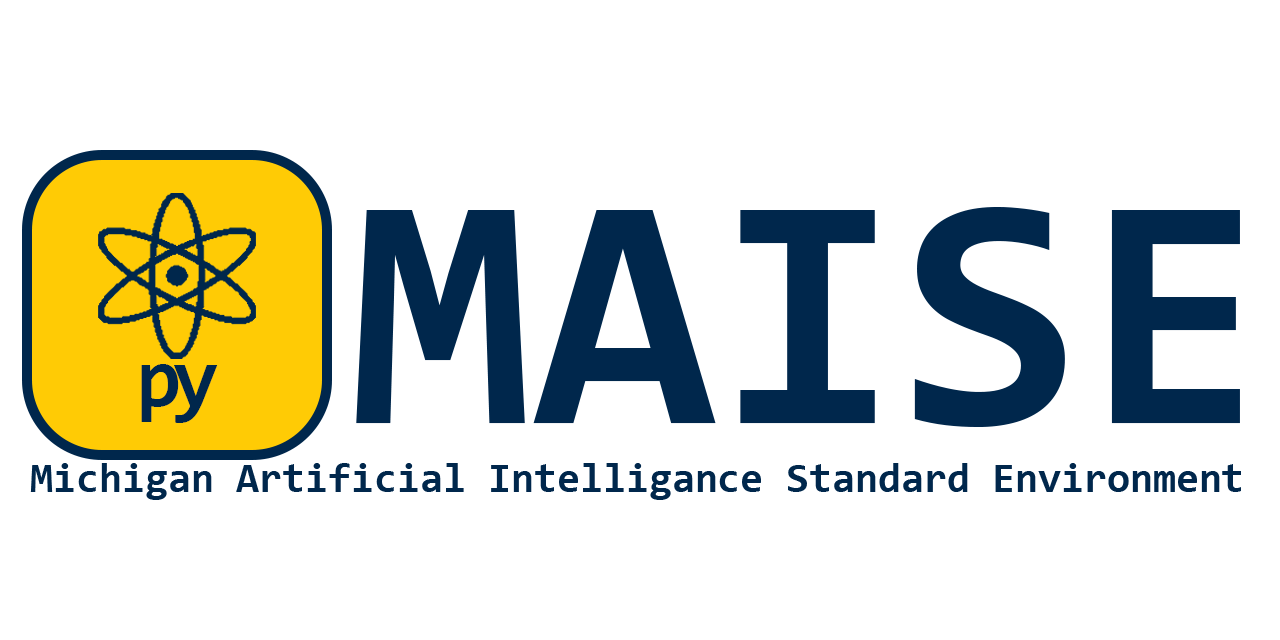